# Noise experiments

In [7]:
import numpy as np
import mnist
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from components.cnn_parallell import experiment1, experiment2, experiment4, experiment6, experiment7, experiment8
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from components.cnn_score import score_clfs_noisy


In [20]:
def save_coefficients(path: str, data: np.ndarray, exp: str):
    folder = f"coefficients/{path}"
    os.makedirs(folder, exist_ok=True)

    file = f"{folder}/{exp}.npy"
    np.save(file, data)
    print(f"{file} saved")

def load_coefficients(path: str, exp: str):
    folder = f"coefficients/{path}"
    file = np.load(f"{folder}/{exp}.npy")
    return file

In [9]:
plt.rcParams["figure.figsize"] = (4,3)


In [36]:
train_imgs = mnist.train_images()/255.0
train_labels = mnist.train_labels()
test_imgs = mnist.test_images()/255.0
test_labels = mnist.test_labels()

data_train = train_imgs[:, 1:, 1:]
data_test = test_imgs[:, 1:, 1:]

In [11]:
noises = [.0, .1, .2, .3, .4, .5]

noisy_test = [np.array([img + np.random.normal(.0, noise, size=(data_test[0].shape)) for img in data_test]) for noise in noises]
noisy_test_flattened = [data.reshape(-1, 27*27) for data in noisy_test]

train_flattened = data_train.reshape(-1, 27*27)

experiments = [
    "Baseline - no threshold",
    "Baseline - 0.7 threshold",
    "Baseline - 0.85 threshold",
    "Experiment 1 - 1 ring",
    "Experiment 2 - 2 rings",
    "Experiment 4 - 3 rings",
    "Experiment 6 - 3 rings + 0.85 threshold",
    "Experiment 7 - Various grid configurations",
    "Experiment 8 - Various grud configurations + 0.85 threshold"
]

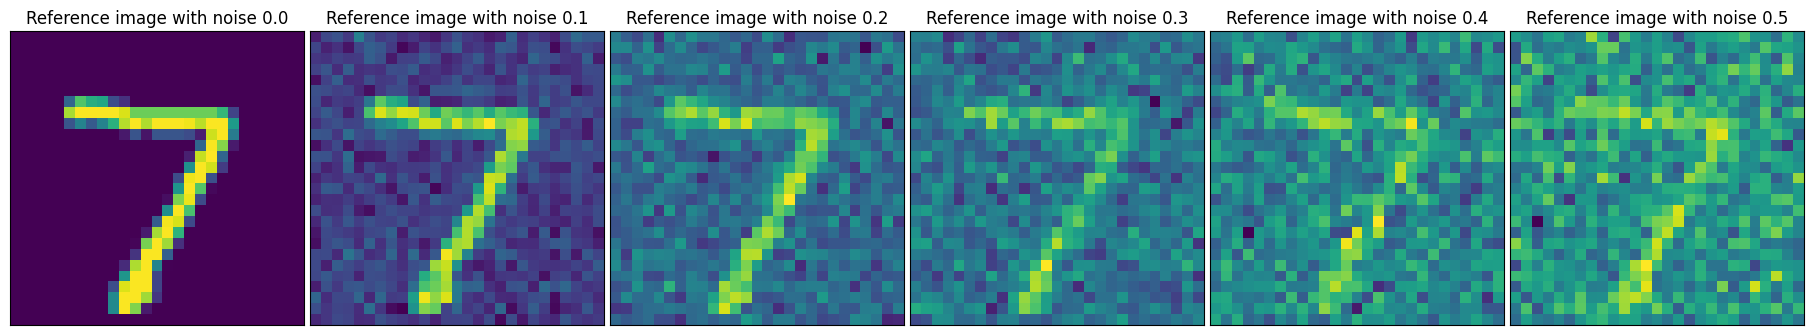

In [12]:
fig, ax = plt.subplots(1, len(noises), figsize=(18, 3))
for i in range(len(noises)): 
    ax[i].imshow(noisy_test[i][0])
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].set_title(f"Reference image with noise {noises[i]}")
plt.tight_layout(pad=0.0)


## Comparing performance on noisy mnist

In [13]:
lr_best_tols = {
    "baseline": 0.01,
    "exp1": 0.001,
    "exp2": 0.001,
    "exp4": 0.0005,
    "exp6": 0.005,
    "exp7": 0.005,
    "exp8": 0.005
}

scores_noisy_lr = []

In [26]:
lr_best_tols = {
    "baseline": 0.01,
    "exp1": 0.001,
    "exp2": 0.001,
    "exp4": 0.0005,
    "exp6": 0.005,
    "exp7": 0.005,
    "exp8": 0.005
}

### Logistic regression

#### Baseline - LR - No thresholding

In [14]:
clfs_bl = [LogisticRegression(fit_intercept=True,
                              multi_class='multinomial',
                              penalty='l2',
                              solver='saga',
                              max_iter=1000,
                              n_jobs=8,
                              tol=lr_best_tols["baseline"]) for _ in range(len(noises))]
baseline_lr_scores = score_clfs_noisy(clfs_bl, train_flattened, train_labels, noisy_test_flattened, test_labels)
scores_noisy_lr.append(baseline_lr_scores)
baseline_lr_scores

[0.9261, 0.9108, 0.8591, 0.7758, 0.6967, 0.6209]

In [31]:
scores_noisy_lr.append([0.9259, 0.915, 0.864, 0.7825, 0.6849, 0.6111])

Text(3.972222222222223, 0.5, 'Accuracy score')

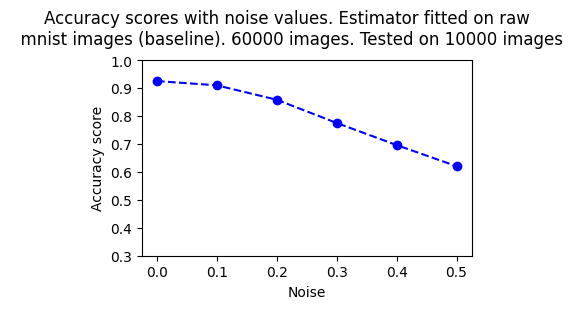

In [15]:
plt.plot([str(t) for t in noises], baseline_lr_scores, linestyle='--', marker='o', color='b', label='Accuracy score')
plt.tight_layout(rect=(0., 0.03, 1., 0.86))
plt.suptitle(f"Accuracy scores with noise values. Estimator fitted on raw\n  mnist images (baseline). {data_train.shape[0]} images. Tested on {data_test.shape[0]} images")
plt.ylim([.3, 1.])
plt.xlabel("Noise") 
plt.ylabel("Accuracy score") 

#### Baseline - LR - 0.7 thresholding

In [16]:
clfs_bl_threshold1 = [LogisticRegression(fit_intercept=True,
                                         multi_class='multinomial',
                                         penalty='l2',
                                         solver='saga',
                                         max_iter=1000,
                                         n_jobs=64,
                                         tol=lr_best_tols["baseline"]) for _ in range(len(noises))]

train_flattened_threshold1 = np.where(train_flattened > 0.7, train_flattened, 0.)
noisy_test_flattened_threshold1 = [np.where(n > 0.7, n, 0.) for n in noisy_test_flattened]

baseline_lr_scores_1 = score_clfs_noisy(clfs_bl_threshold1, train_flattened_threshold1, train_labels, noisy_test_flattened_threshold1, test_labels)
scores_noisy_lr.append(baseline_lr_scores_1)
baseline_lr_scores_1

[0.9161, 0.9135, 0.9015, 0.8683, 0.7431, 0.5776]

#### Baseline - LR - 0.85 thresholding

In [17]:
clfs_bl_threshold2 = [LogisticRegression(fit_intercept=True,
                                         multi_class='multinomial',
                                         penalty='l2',
                                         solver='saga',
                                         max_iter=1000,
                                         n_jobs=64,
                                         tol=lr_best_tols["baseline"]) for _ in range(len(noises))]

train_flattened_threshold2 = np.where(train_flattened > 0.85, train_flattened, 0.)
noisy_test_flattened_threshold2 = [np.where(n > 0.85, n, 0.) for n in noisy_test_flattened]

baseline_lr_scores_2 = score_clfs_noisy(clfs_bl_threshold2, train_flattened_threshold2, train_labels, noisy_test_flattened_threshold2, test_labels)
scores_noisy_lr.append(baseline_lr_scores_2)
baseline_lr_scores_2

[0.9037, 0.8928, 0.8758, 0.8535, 0.7882, 0.6447]

#### Experiment 1 - LR

In [18]:
exp_1_train_transformed = experiment1(data_train)
exp_1_test_transformed = [experiment1(test) for test in noisy_test]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [21]:
save_coefficients("train", exp_1_train_transformed, "experiment_1_train")
[save_coefficients("test", t, f"experiment1/noise_test_{i}") for i, t in enumerate(exp_1_test_transformed)]

coefficients/train/experiment_1_train.npy saved


In [22]:
clfs_lr_ex1 = [LogisticRegression(fit_intercept=True,
                           multi_class='multinomial',
                           penalty='l2',
                           solver='saga',
                           max_iter=1000,
                           n_jobs=64,
                           tol=lr_best_tols["exp1"]) for _ in range(len(noises))]

lr_noisy_exp2_score = score_clfs_noisy(clfs_lr_ex1, exp_1_train_transformed, train_labels, exp_1_test_transformed, test_labels)                        
scores_noisy_lr.append(lr_noisy_exp2_score)
lr_noisy_exp2_score

[0.9238, 0.8987, 0.8651, 0.806, 0.7003, 0.5716]

In [33]:
scores_noisy_lr.append([0.9238, 0.8955, 0.8683, 0.8028, 0.6999, 0.5633])

#### Experiment 2 - LR

In [23]:
exp_2_train_transformed = experiment2(data_train)
exp_2_test_transformed = [experiment2(test) for test in noisy_test]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [24]:
save_coefficients("train", exp_2_train_transformed, "experiment_2_train")
[save_coefficients("test", t, f"experiment2/noise_test_{i}") for i, t in enumerate(exp_2_test_transformed)]

coefficients/train/experiment_2_train.npy saved


In [25]:
clfs_lr_ex2 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=lr_best_tols["exp2"]) for _ in range(len(noises))]

lr_noisy_exp2_score = score_clfs_noisy(clfs_lr_ex2, exp_2_train_transformed, train_labels, exp_2_test_transformed, test_labels)                        
scores_noisy_lr.append(lr_noisy_exp2_score)
lr_noisy_exp2_score

[0.9461, 0.7513, 0.6833, 0.594, 0.4706, 0.3755]

In [34]:
scores_noisy_lr.append([0.9461, 0.7486, 0.6787, 0.5898, 0.478, 0.3759])

### Experiment 4 - LR

In [27]:
exp_4_train_transformed = experiment4(data_train)
exp_4_test_transformed = [experiment4(test) for test in noisy_test]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [28]:
clfs_lr_ex4 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=lr_best_tols["exp4"]) for _ in range(len(noises))]

lr_noisy_exp4_score = score_clfs_noisy(clfs_lr_ex4, exp_4_train_transformed, train_labels, exp_4_test_transformed, test_labels)
scores_noisy_lr.append(lr_noisy_exp4_score)
lr_noisy_exp4_score

[0.9713, 0.7984, 0.7507, 0.6748, 0.5664, 0.4406]

In [34]:
save_coefficients("train", exp_4_train_transformed, "experiment_4_train")
[save_coefficients("test", t, f"experiment4/noise_test_{i}") for i, t in enumerate(exp_4_test_transformed)]

coefficients/train/experiment_4_train.npy saved


In [36]:
scores_noisy_lr.append([0.971, 0.7897, 0.7347, 0.653, 0.5363, 0.4266])

### Experiment 6 - LR

In [29]:
exp_6_train_transformed = experiment6(data_train, threshold=0.85)
exp_6_test_transformed = [experiment6(test, threshold=0.85) for test in noisy_test]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [30]:
clfs_lr_ex6 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=lr_best_tols["exp6"]) for _ in range(len(noises))]

lr_noisy_exp6_score = score_clfs_noisy(clfs_lr_ex6, exp_6_train_transformed, train_labels, exp_6_test_transformed, test_labels)
scores_noisy_lr.append(lr_noisy_exp6_score)
lr_noisy_exp6_score

[0.9305, 0.9254, 0.9071, 0.818, 0.5687, 0.2882]

In [37]:
scores_noisy_lr.append([0.975, 0.8832, 0.8533, 0.8028, 0.68919, 0.584])

In [33]:
save_coefficients("train", exp_6_train_transformed, "experiment_6_train")
[save_coefficients("test", t, f"experiment6/noise_test_{i}") for i, t in enumerate(exp_6_test_transformed)]

coefficients/train/experiment_6_train.npy saved


### Experiment 7 - LR

In [37]:
exp_7_train_transformed = experiment7(data_train)
exp_7_test_transformed = [experiment7(test) for test in noisy_test]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [ ]:
clfs_lr_ex7 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=lr_best_tols["exp7"]) for _ in range(len(noises))]

lr_noisy_exp7_score = score_clfs_noisy(clfs_lr_ex7, exp_7_train_transformed, train_labels, exp_7_test_transformed, test_labels)
scores_noisy_lr.append(lr_noisy_exp7_score)
lr_noisy_exp7_score

[0.9326]

In [38]:
scores_noisy_lr.append([0.9326, 0.9282, 0.9067, 0.8051, 0.5582, 0.3099])

In [ ]:
save_coefficients("train", exp_7_train_transformed, "experiment_7_train")
[save_coefficients("test", t, f"experiment7/noise_test_{i}") for i, t in enumerate(exp_7_test_transformed)]

### Experiment 8 - LR

In [ ]:
exp_8_train_transformed = experiment8(data_train, threshold=0.85)
exp_8_test_transformed = [experiment8(test, threshold=0.85) for test in noisy_test]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [ ]:
clfs_lr_ex8 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=64,
                                  tol=0.001) for _ in range(len(noises))]

lr_noisy_exp8_score = score_clfs_noisy(clfs_lr_ex8, exp_8_train_transformed, train_labels, exp_8_test_transformed, test_labels)
scores_noisy_lr.append(lr_noisy_exp8_score)
lr_noisy_exp8_score

[0.9791]

In [ ]:
save_coefficients("train", exp_8_train_transformed, "experiment_8_train")
[save_coefficients("test", t, f"experiment8/noise_test_{i}") for i, t in enumerate(exp_8_test_transformed)]

In [39]:
scores_noisy_lr.append([0.9791, 0.933, 0.8832, 0.8353, 0.7629, 0.6705])

### Results from LR

Text(0.5, 0.98, 'Trained on MNIST with LR estimator, tested on noisy images. \nTrained on 60000 images. Tested on 10000 images')

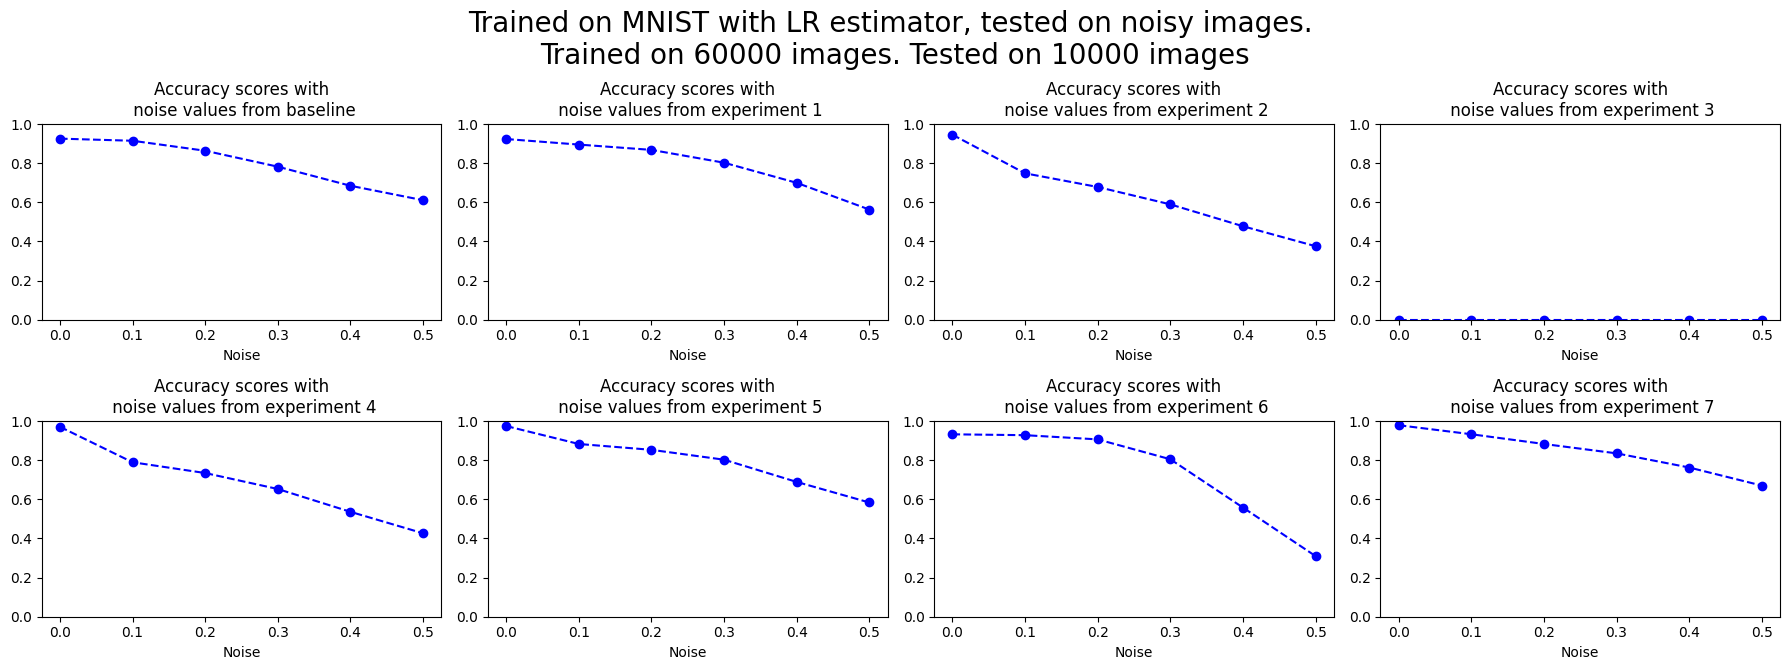

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
for i in range(9):
    k, j = i // 3, i % 3
    ax[k][j].plot([str(t) for t in noises], scores_noisy_lr[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n noise values from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Noise") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with LR estimator, tested on noisy images. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)
#fig.delaxes(ax[1,3])

### SVM

In [41]:
svm_best_Cs = {
    "baseline": 10.,
    "exp1": 500.,
    "exp2": 500.,
    "exp3": 500.,
    "exp4": 500.,
    "exp5": 500.,
    "exp6": 10.,
    "exp7": 10.,
    "exp8": 10.
}

scores_noisy_svm = []

#### Baseline - SVM - No thresholding

In [9]:
clfs_svm_bl = [SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto") for _ in range(len(noises))]
baseline_svm_scores = score_clfs_noisy(clfs_svm_bl, train_flattened, train_labels, noisy_test_flattened, test_labels)
scores_noisy_svm.append(baseline_svm_scores)
baseline_svm_scores

[0.9624]

In [42]:
scores_noisy_svm.append([0.9624, 0.9615, 0.9477, 0.8996, 0.8081, 0.7028])

[0.9615, 0.9477, 0.8996, 0.8081, 0.7028]

#### Baseline - SVM - 0.7 threshold

In [ ]:
clfs_svm_bl_thr1 = [SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto") for _ in range(len(noises))]

train_flattened_threshold1 = np.where(train_flattened > 0.7, train_flattened, 0.)
noisy_test_flattened_threshold1 = [np.where(n > 0.7, n, 0.) for n in noisy_test_flattened]

baseline_svm_scores_thr1 = score_clfs_noisy(clfs_svm_bl_thr1, train_flattened_threshold1, train_labels, noisy_test_flattened_threshold1, test_labels)
scores_noisy_svm.append(baseline_svm_scores_thr1)
baseline_svm_scores_thr1

#### Baseline - SVM - 0.85 threshold

In [ ]:
clfs_svm_bl_thr2 = [SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto") for _ in range(len(noises))]

train_flattened_threshold2 = np.where(train_flattened > 0.85, train_flattened, 0.)
noisy_test_flattened_threshold2 = [np.where(n > 0.85, n, 0.) for n in noisy_test_flattened]

baseline_svm_scores_thr2 = score_clfs_noisy(clfs_svm_bl_thr2, train_flattened_threshold2, train_labels, noisy_test_flattened_threshold2, test_labels)
scores_noisy_svm.append(baseline_svm_scores_thr2)
baseline_svm_scores_thr2

#### Experiment 1 - SVM

In [12]:
clfs_svm_exp1 = [SVC(kernel='rbf', C=svm_best_Cs["exp1"], gamma="auto") for _ in range(len(noises))]
scores_noisy_exp1_svm = score_clfs_noisy(clfs_svm_exp1, exp_1_train_transformed, train_labels, exp_1_test_transformed, test_labels)
scores_noisy_svm.append(scores_noisy_exp1_svm)
scores_noisy_exp1_svm

[0.9534]

In [43]:
scores_noisy_svm.append([0.9534, 0.9222, 0.8856, 0.8107, 0.6753, 0.5158])

[0.9222, 0.8856, 0.8107, 0.6753, 0.5158]

#### Experiment 2 - SVM

In [16]:
clfs_svm_exp2 = [SVC(kernel='rbf', C=svm_best_Cs["exp2"], gamma="auto") for _ in range(len(noises))]
scores_noisy_exp2_svm = score_clfs_noisy(clfs_svm_exp2, exp_2_train_transformed, train_labels, exp_2_test_transformed, test_labels)
scores_noisy_svm.append(scores_noisy_exp2_svm)
scores_noisy_exp2_svm

[0.9741]

In [44]:
scores_noisy_svm.append([0.9741, 0.6647, 0.6021, 0.5019, 0.378, 0.2879])

[0.6647, 0.6021, 0.5019, 0.378, 0.2879]

#### Experiment 4 - SVM

In [17]:
clfs_svm_exp4 = [SVC(kernel='rbf', C=svm_best_Cs["exp4"], gamma="auto") for _ in range(len(noises))]
scores_noisy_exp4_svm = score_clfs_noisy(clfs_svm_exp4, exp_4_train_transformed, train_labels, exp_4_test_transformed, test_labels)
scores_noisy_svm.append(scores_noisy_exp4_svm)
scores_noisy_exp4_svm

[0.9843]

In [46]:
scores_noisy_svm.append([0.9843, 0.7194, 0.6445, 0.5425, 0.4201, 0.3219])

[0.7194, 0.6445, 0.5425, 0.4201, 0.3219]

#### Experiment 6 - SVM

In [23]:
clfs_svm_exp6 = [SVC(kernel='rbf', C=svm_best_Cs["exp6"], gamma="auto") for _ in range(len(noises))]
scores_noisy_exp6_svm = score_clfs_noisy(clfs_svm_exp6, exp_6_train_transformed, train_labels, exp_6_test_transformed, test_labels)
scores_noisy_svm.append(scores_noisy_exp6_svm)
scores_noisy_exp6_svm

[0.9497]

In [48]:
scores_noisy_svm.append([0.9864, 0.9461, 0.9287, 0.838, 0.5989, 0.3432])

[0.9461, 0.9287, 0.838, 0.5989, 0.3432]

#### Experiment 7 - SVM

In [24]:
clfs_svm_exp7 = [SVC(kernel='rbf', C=500., gamma="auto") for _ in range(len(noises))]
scores_noisy_exp7_svm = score_clfs_noisy(clfs_svm_exp7, exp_7_train_transformed, train_labels, exp_7_test_transformed, test_labels)
scores_noisy_svm.append(scores_noisy_exp7_svm)
scores_noisy_exp7_svm

[0.9876]

In [49]:
scores_noisy_svm.append([0.9876, 0.9251, 0.8668, 0.7956, 0.6811, 0.5483])

[0.9251, 0.8668, 0.7956, 0.6811, 0.5483]

#### Experiment 8 - SVM

In [ ]:
clfs_svm_exp8 = [SVC(kernel='rbf', C=svm_best_Cs["exp8"], gamma="auto") for _ in range(len(noises))]
scores_noisy_exp8_svm = score_clfs_noisy(clfs_svm_exp8, exp_8_train_transformed, train_labels, exp_8_test_transformed, test_labels)
scores_noisy_svm.append(scores_noisy_exp8_svm)
scores_noisy_exp8_svm

### Results from SVM

Text(0.5, 0.98, 'Trained on MNIST with SVM estimator, tested on noisy images. \nTrained on 60000 images. Tested on 10000 images')

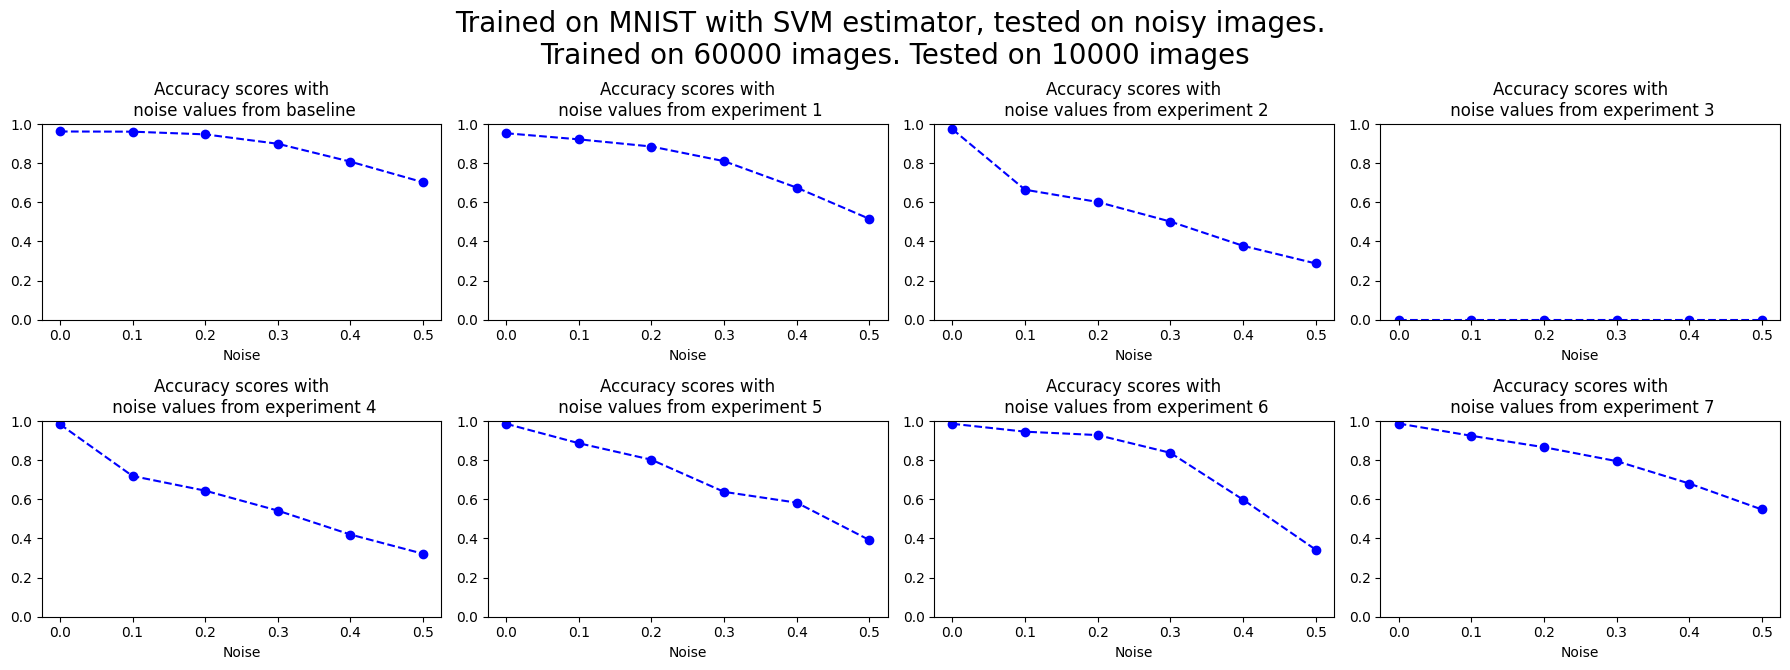

In [50]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
for i in range(9):
    k, j = i // 3, i % 3
    ax[k][j].plot([str(t) for t in noises], scores_noisy_svm[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n noise values from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Noise") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with SVM estimator, tested on noisy images. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)

#### KNN

In [60]:
from sklearn.neighbors import KNeighborsClassifier

scores_noisy_knn = []

#### Baseline - KNN - No thresholding

In [ ]:
clfs_knn_bl = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores = score_clfs_noisy(clfs_knn_bl, train_flattened, train_labels, noisy_test_flattened, test_labels)
scores_noisy_knn.append(baseline_knn_scores)
baseline_knn_scores

#### Baseline - KNN - 0.7 threshold

In [ ]:
clfs_knn_bl_thr1 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores_thr1 = score_clfs_noisy(clfs_knn_bl_thr1, train_flattened_threshold1, train_labels, noisy_test_flattened_threshold1, test_labels)
scores_noisy_knn.append(baseline_knn_scores_thr1)
baseline_knn_scores_thr1

#### Baseline - KNN - 0.85 threshold

In [ ]:
clfs_knn_bl_thr2 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores_thr2 = score_clfs_noisy(clfs_knn_bl_thr2, train_flattened_threshold2, train_labels, noisy_test_flattened_threshold2, test_labels)
scores_noisy_knn.append(baseline_knn_scores_thr2)
baseline_knn_scores_thr2

#### Experiment 1 - KNN

In [67]:
clfs_knn_exp1 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp1_knn = score_clfs_noisy(clfs_knn_exp1, exp_1_train_transformed, train_labels, exp_1_test_transformed, test_labels)
scores_noisy_knn.append(scores_noisy_exp1_knn)
scores_noisy_exp1_knn

[0.9411]

#### Experiment 2 - KNN

In [69]:
clfs_knn_exp2 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp2_knn = score_clfs_noisy(clfs_knn_exp2, exp_2_train_transformed, train_labels, exp_2_test_transformed, test_labels)
scores_noisy_knn.append(scores_noisy_exp2_knn)
scores_noisy_exp2_knn

[0.8856]

#### Experiment 4 - KNN

In [ ]:
clfs_knn_exp4 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp4_knn = score_clfs_noisy(clfs_knn_exp4, exp_4_train_transformed, train_labels, exp_4_test_transformed, test_labels)
scores_noisy_knn.append(scores_noisy_exp4_knn)
scores_noisy_exp4_knn

#### Experiment 6 - KNN

In [ ]:
clfs_knn_exp6 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp6_knn = score_clfs_noisy(clfs_knn_exp6, exp_6_train_transformed, train_labels, exp_6_test_transformed, test_labels)
scores_noisy_knn.append(scores_noisy_exp6_knn)
scores_noisy_exp6_knn

#### Experiment 7 - KNN

In [ ]:
clfs_knn_exp7 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp7_knn = score_clfs_noisy(clfs_knn_exp7, exp_7_train_transformed, train_labels, exp_7_test_transformed, test_labels)
scores_noisy_knn.append(scores_noisy_exp7_knn)
scores_noisy_exp7_knn

#### Experiment 8 - KNN

In [ ]:
clfs_knn_exp8 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
scores_noisy_exp8_knn = score_clfs_noisy(clfs_knn_exp8, exp_8_train_transformed, train_labels, exp_8_test_transformed, test_labels)
scores_noisy_knn.append(scores_noisy_exp8_knn)
scores_noisy_exp8_knn

#### Results from KNN (Noise)

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
for i in range(9):
    k, j = i // 3, i % 3
    ax[k][j].plot([str(t) for t in noises], scores_noisy_knn[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n noise values from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Noise") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with KNN estimator, tested on noisy images. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)

### Testing with CNN - Baseline

In [70]:
cnn_scores_noise = []

In [71]:
from tensorflow import keras
from tensorflow.keras import layers

2024-05-14 03:01:11.659424: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 03:01:11.662427: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 03:01:11.703672: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 03:01:12.488645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [72]:
mnist_train_pixelshape = [np.expand_dims(data, -1) for data in data_train]
mnist_test_pixelshape = [np.expand_dims(data, -1) for data in data_test]

input_shape = mnist_train_pixelshape[0].shape[-3:]
classes = np.unique(train_labels).shape[0]
train_labels_binary = keras.utils.to_categorical(train_labels, classes)
test_labels_binary = keras.utils.to_categorical(test_labels, classes)

In [73]:
def make_model_baseline(input_shape, num_classes):
    return keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

cnn_noises = [.0, .1, .2, .3, .4, .5]

def add_noise(std, img, shape):
    noi = np.random.normal(.0, std, size=shape)
    return img + noi[..., np.newaxis]


def score_cnn(clfs, X_train, y_train, X_test, y_test):
    scores = []
    batch_size = 128
    epochs = 15
    X_tr = np.array(X_train)

    for i, clf in enumerate(clfs):
        X_te = np.array([add_noise(cnn_noises[i], img, (27, 27)) for img in X_test])
        clf.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        clf.fit(X_tr, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        scores.append(clf.evaluate(X_te, y_test, verbose=0)[1])
    return scores

In [74]:
clfs_bl_cnn = [make_model_baseline(input_shape=input_shape, num_classes=classes) for _ in range(len(cnn_noises))]
cnn_scores_noise.append(score_cnn(clfs_bl_cnn, mnist_train_pixelshape, train_labels_binary, mnist_test_pixelshape, test_labels_binary))

Text(0.5, 1.0, 'CNN accuracy scores with noise values from baseline, LR')

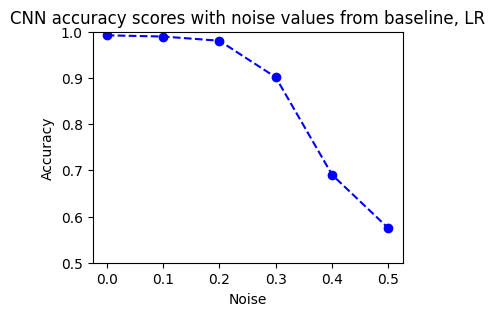

In [75]:
plt.plot([str(t) for t in cnn_noises], cnn_scores_noise[0], linestyle='--', marker='o', color='b', label='Accuracy score')
plt.ylim([.5, 1.])
plt.ylabel("Accuracy")
plt.xlabel("Noise")
plt.title("CNN accuracy scores with noise values from baseline, LR")


## Another type of noise: image blackouts

In [76]:
def black_out_section(image, size):
    offset = 28 - size
    start_row = np.random.randint(3, offset-3)
    start_col = np.random.randint(3, offset-3)
    image_copy = image.copy()
    image_copy[start_row:start_row+size, start_col:start_col+size] = 0
    return image_copy

blackout_sizes = np.arange(0, 18, 3)
blackout_tests = [np.array([black_out_section(img, size) for img in data_test]) for size in blackout_sizes]

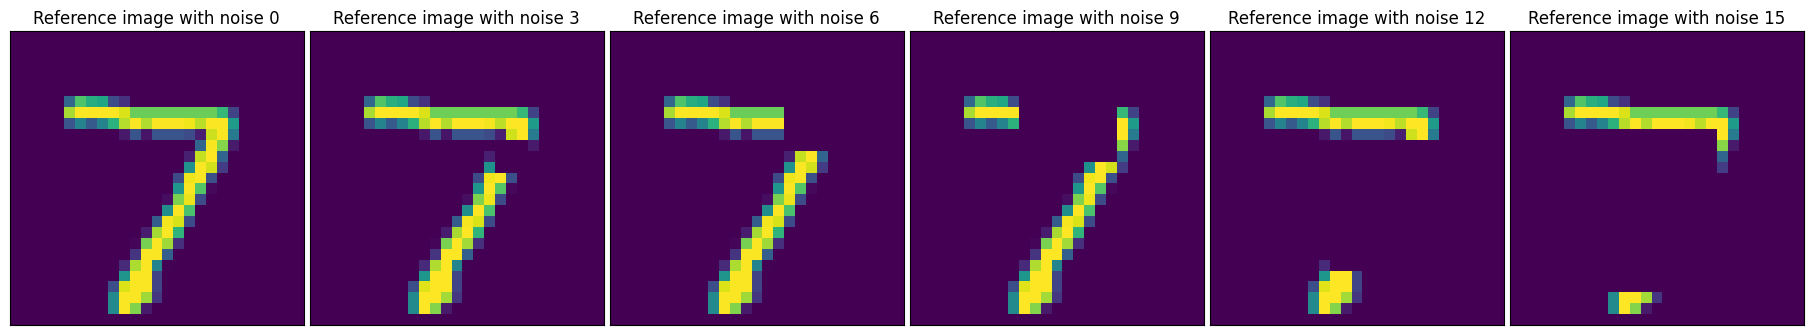

In [77]:
fig, ax = plt.subplots(1, len(blackout_sizes), figsize=(18, 3))
for i in range(len(blackout_sizes)): 
    ax[i].imshow(blackout_tests[i][0])
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].set_title(f"Reference image with blackout with size {blackout_sizes[i]}")
plt.tight_layout(pad=0.0)

### LR

In [78]:
scores_blackout_lr = []

### Baseline - LR - No thresholding

In [79]:
blackout_test_flattened = [data.reshape(-1, 27*27) for data in blackout_tests]

In [80]:
clfs_bl_lr = [LogisticRegression(fit_intercept=True,
                                 multi_class='multinomial',
                                 penalty='l2',
                                 solver='saga',
                                 max_iter=1000,
                                 n_jobs=8,
                                 tol=lr_best_tols["baseline"]) for _ in range(len(blackout_sizes))]

scores_blackout_baseline_lr = score_clfs_noisy(clfs_bl_lr, train_flattened, train_labels, blackout_test_flattened, test_labels)
scores_blackout_lr.append(scores_blackout_baseline_lr)
scores_blackout_baseline_lr

[0.926, 0.9178, 0.8098, 0.566, 0.3439, 0.2737]

### Baseline - LR - 0.7 threshold

In [ ]:
clfs_bl_lr_thr1 = [LogisticRegression(fit_intercept=True,
                                 multi_class='multinomial',
                                 penalty='l2',
                                 solver='saga',
                                 max_iter=1000,
                                 n_jobs=8,
                                 tol=lr_best_tols["baseline"]) for _ in range(len(blackout_sizes))]

train_flattened_blackout_threshold1 = np.where(train_flattened > 0.7, train_flattened, 0.)
test_flattened_blackout_threshold1 = [np.where(n > 0.7, n, 0.) for n in blackout_test_flattened]

scores_blackout_baseline_lr_thr1 = score_clfs_noisy(clfs_bl_lr_thr1, 
                                                    train_flattened_blackout_threshold1, 
                                                    train_labels, 
                                                    test_flattened_blackout_threshold1, 
                                                    test_labels)

scores_blackout_lr.append(scores_blackout_baseline_lr_thr1)
scores_blackout_baseline_lr_thr1

### Baseline - LR - 0.85 threshold

In [ ]:
clfs_bl_lr_thr2 = [LogisticRegression(fit_intercept=True,
                                 multi_class='multinomial',
                                 penalty='l2',
                                 solver='saga',
                                 max_iter=1000,
                                 n_jobs=8,
                                 tol=lr_best_tols["baseline"]) for _ in range(len(blackout_sizes))]

train_flattened_blackout_threshold2 = np.where(train_flattened > 0.85, train_flattened, 0.)
test_flattened_blackout_threshold2 = [np.where(n > 0.85, n, 0.) for n in blackout_test_flattened]

scores_blackout_baseline_lr_thr2 = score_clfs_noisy(clfs_bl_lr_thr2, 
                                                    train_flattened_blackout_threshold2, 
                                                    train_labels, 
                                                    test_flattened_blackout_threshold2, 
                                                    test_labels)

scores_blackout_lr.append(scores_blackout_baseline_lr_thr2)
scores_blackout_baseline_lr_thr2

#### Experiment 1

In [90]:
exp_1_test_blackout_transformed = [experiment1(test) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [91]:
clfs_lr_ex1_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=64,
                                           tol=lr_best_tols["exp1"]) for _ in range(len(blackout_sizes))]

scores_blackout_exp1_lr = score_clfs_noisy(clfs_lr_ex1_blackout, exp_1_train_transformed, train_labels, exp_1_test_blackout_transformed, test_labels)
scores_blackout_lr.append(scores_blackout_exp1_lr)
scores_blackout_exp1_lr

[0.9237, 0.911, 0.8095, 0.5211, 0.2488, 0.1148]

In [ ]:
[save_coefficients("test", t, f"experiment1/blackout_test_{blackout_sizes[i]}") for i, t in enumerate(exp_1_test_blackout_transformed)]

In [ ]:
scores_blackout_lr.append([0.9113, 0.8035, 0.524, 0.265, 0.1252])

#### Experiment 2

In [92]:
exp_2_test_blackout_transformed = [experiment2(test) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [93]:
clfs_lr_ex2_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=lr_best_tols["exp2"]) for _ in range(len(blackout_sizes))]

scores_blackout_exp2_lr = score_clfs_noisy(clfs_lr_ex2_blackout, exp_2_train_transformed, train_labels, exp_2_test_blackout_transformed, test_labels)
scores_blackout_lr.append(scores_blackout_exp2_lr)
scores_blackout_exp2_lr

[0.9461, 0.9362, 0.8735, 0.6556, 0.3498, 0.1683]

In [ ]:
scores_blackout_lr.append([0.9403, 0.8715, 0.6546, 0.3551, 0.1766])

In [ ]:
[save_coefficients("test", t, f"experiment2/blackout_test_{blackout_sizes[i]}") for i, t in enumerate(exp_2_test_blackout_transformed)]

#### Experiment 4

In [95]:
exp_4_test_blackout_transformed = [experiment4(test) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [96]:
clfs_lr_ex4_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=lr_best_tols["exp4"]) for _ in range(len(blackout_sizes))]

scores_blackout_exp4_lr = score_clfs_noisy(clfs_lr_ex4_blackout, exp_4_train_transformed, train_labels, exp_4_test_blackout_transformed, test_labels)
scores_blackout_lr.append(scores_blackout_exp4_lr)
scores_blackout_exp4_lr

[0.971, 0.9652, 0.9129, 0.6957, 0.3808, 0.1875]

In [ ]:
scores_blackout_lr.append([0.9662, 0.9084, 0.7113, 0.3821, 0.2027])

In [ ]:
[save_coefficients("test", t, f"experiment4/blackout_test_{blackout_sizes[i]}") for i, t in enumerate(exp_4_test_blackout_transformed)]

#### Experiment 6

In [99]:
exp_6_test_blackout_transformed = [experiment6(test, threshold=0.85) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [100]:
clfs_lr_ex6_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=lr_best_tols["exp6"]) for _ in range(len(blackout_sizes))]

scores_blackout_exp6_lr = score_clfs_noisy(clfs_lr_ex6_blackout, exp_6_train_transformed, train_labels, exp_6_test_blackout_transformed, test_labels)
scores_blackout_lr.append(scores_blackout_exp6_lr)
scores_blackout_exp6_lr

[0.9326, 0.9189, 0.8607, 0.7351, 0.5541, 0.3414]

In [ ]:
scores_blackout_lr.append([0.9201, 0.8545, 0.7403, 0.5596, 0.3443])

In [ ]:
[save_coefficients("test", t, f"experiment6/blackout_test_{blackout_sizes[i]}") for i, t in enumerate(exp_6_test_blackout_transformed)]

#### Experiment 7

In [101]:
exp_7_test_blackout_transformed = [experiment7(test) for test in blackout_tests]

/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
/home/student/master-experiments/components/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) 

In [102]:
clfs_lr_ex7_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=.001) for _ in range(len(blackout_sizes))]

scores_blackout_exp7_lr = score_clfs_noisy(clfs_lr_ex7_blackout, exp_7_train_transformed, train_labels, exp_7_test_blackout_transformed, test_labels)
scores_blackout_lr.append(scores_blackout_exp7_lr)
scores_blackout_exp7_lr

[0.979, 0.9739, 0.8855, 0.5879, 0.3033, 0.1542]

In [ ]:
[save_coefficients("test", t, f"experiment7/blackout_test_{blackout_sizes[i]}") for i, t in enumerate(exp_7_test_blackout_transformed)]

#### Experiment 8

In [ ]:
exp_8_test_blackout_transformed = [experiment8(test, threshold=0.85) for test in blackout_tests]

In [ ]:
clfs_lr_ex8_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=lr_best_tols["exp8"]) for _ in range(len(blackout_sizes))]

scores_blackout_exp8_lr = score_clfs_noisy(clfs_lr_ex8_blackout, exp_8_train_transformed, train_labels, exp_8_test_blackout_transformed, test_labels)
scores_blackout_lr.append(scores_blackout_exp8_lr)
scores_blackout_exp8_lr

In [ ]:
[save_coefficients("test", t, f"experiment8/blackout_test_{blackout_sizes[i]}") for i, t in enumerate(exp_8_test_blackout_transformed)]

### Results - Blackout - LR

Text(0.5, 0.98, 'Trained on MNIST with LR estimator, tested on images with blackouts. \nTrained on 60000 images. Tested on 10000 images')

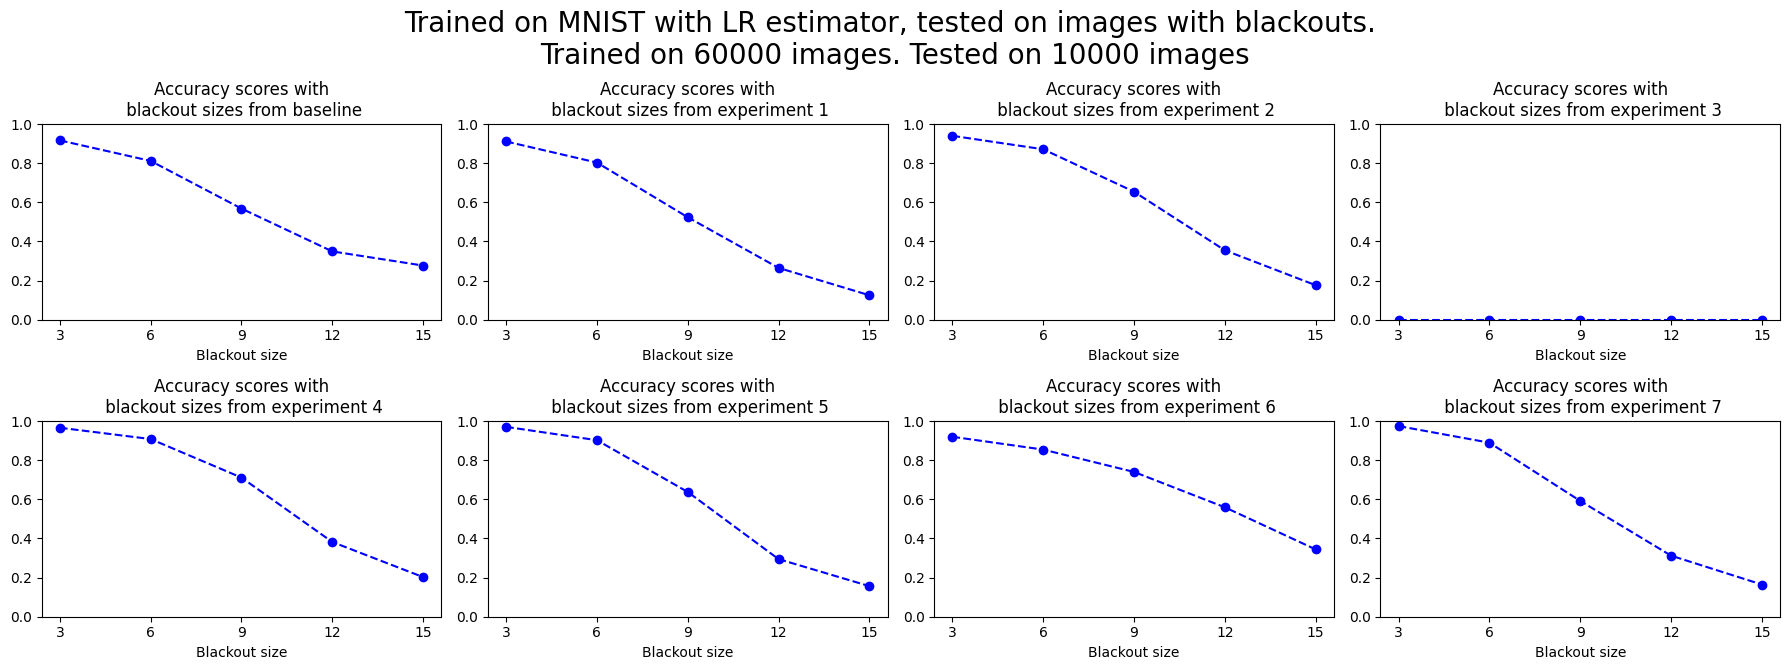

In [101]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
for i in range(9):
    k, j = i // 3, i % 3
    ax[k][j].plot([str(t) for t in blackout_sizes], scores_blackout_lr[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n blackout sizes from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Blackout size") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with LR estimator, tested on images with blackouts. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)

### SVM

In [103]:
scores_blackout_svm = []

#### Baseline - SVM - No thresholding

In [104]:
clfs_svm_blackout_bl = [SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_baseline_svm = score_clfs_noisy(clfs_svm_blackout_bl, train_flattened, train_labels, blackout_test_flattened, test_labels)
scores_blackout_svm.append(scores_blackout_baseline_svm)
scores_blackout_baseline_svm

[0.9624, 0.9575, 0.8573, 0.6252, 0.3999, 0.2675]

In [ ]:
scores_blackout_svm.append([0.9572, 0.8588, 0.6328, 0.4091, 0.278])

#### Baseline - SVM - 0.7 threshold

In [ ]:
clfs_svm_blackout_bl_thr1 = [SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_baseline_svm_thr1 = score_clfs_noisy(clfs_svm_blackout_bl_thr1,
                                                    train_flattened_blackout_threshold1, 
                                                    train_labels, 
                                                    test_flattened_blackout_threshold1, 
                                                    test_labels)

scores_blackout_svm.append(scores_blackout_baseline_svm_thr1)
scores_blackout_baseline_svm_thr1

#### Baseline - SVM - 0.85 threshold

In [ ]:
clfs_svm_blackout_bl_thr2 = [SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_baseline_svm_thr2 = score_clfs_noisy(clfs_svm_blackout_bl_thr2,
                                                    train_flattened_blackout_threshold2, 
                                                    train_labels, 
                                                    test_flattened_blackout_threshold2, 
                                                    test_labels)

scores_blackout_svm.append(scores_blackout_baseline_svm_thr2)
scores_blackout_baseline_svm_thr2

#### Experiment 1 - SVM

In [105]:
clfs_svm_exp1_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp1"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp1_svm = score_clfs_noisy(clfs_svm_exp1_blackout, exp_1_train_transformed, train_labels, exp_1_test_blackout_transformed, test_labels)
scores_blackout_svm.append(scores_blackout_exp1_svm)
scores_blackout_exp1_svm

[0.9534, 0.9387, 0.8283, 0.5565, 0.2899, 0.1514]

In [ ]:
scores_blackout_svm.append([])

#### Experiment 2 - SVM

In [106]:
clfs_svm_exp2_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp2"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp2_svm = score_clfs_noisy(clfs_svm_exp2_blackout, exp_2_train_transformed, train_labels, exp_2_test_blackout_transformed, test_labels)
scores_blackout_svm.append(scores_blackout_exp2_svm)
scores_blackout_exp2_svm

[0.9741, 0.9646, 0.8884, 0.6663, 0.3831, 0.2123]

In [ ]:
scores_blackout_svm.append([0.9657, 0.8887, 0.6711, 0.3814, 0.2184])

#### Experiment 4 - SVM

In [108]:
clfs_svm_exp4_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp4"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp4_svm = score_clfs_noisy(clfs_svm_exp4_blackout, exp_4_train_transformed, train_labels, exp_4_test_blackout_transformed, test_labels)
scores_blackout_svm.append(scores_blackout_exp4_svm)
scores_blackout_exp4_svm

[0.9843, 0.9773, 0.9052, 0.6593, 0.3596, 0.1967]

In [ ]:
scores_blackout_svm.append([0.9779, 0.9068, 0.664, 0.367, 0.2064])

#### Experiment 6 - SVM

In [110]:
clfs_svm_exp6_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp6"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp6_svm = score_clfs_noisy(clfs_svm_exp6_blackout, exp_6_train_transformed, train_labels, exp_6_test_blackout_transformed, test_labels)
scores_blackout_svm.append(scores_blackout_exp6_svm)
scores_blackout_exp6_svm

[0.9497, 0.9367, 0.8797, 0.7448, 0.5718, 0.3688]

In [ ]:
scores_blackout_svm.append([0.9374, 0.8678, 0.7556, 0.5801, 0.368])

#### Experiment 7 - SVM

In [111]:
clfs_svm_exp7_blackout = [SVC(kernel='rbf', C=500., gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp7_svm = score_clfs_noisy(clfs_svm_exp7_blackout, exp_7_train_transformed, train_labels, exp_7_test_blackout_transformed, test_labels)
scores_blackout_svm.append(scores_blackout_exp7_svm)
scores_blackout_exp7_svm

[0.9876, 0.9813, 0.8763, 0.574, 0.3088, 0.2125]

In [ ]:
scores_blackout_svm.append([0.9828, 0.8831, 0.576, 0.3144, 0.2166])

#### Experiment 8 - SVM

In [ ]:
clfs_svm_exp8_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp8"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_exp8_svm = score_clfs_noisy(clfs_svm_exp8_blackout, exp_8_train_transformed, train_labels, exp_8_test_blackout_transformed, test_labels)
scores_blackout_svm.append(scores_blackout_exp8_svm)
scores_blackout_exp8_svm

### Results - SVM

Text(0.5, 0.98, 'Trained on MNIST with SVM estimator, tested images with blackouts. \nTrained on 60000 images. Tested on 10000 images')

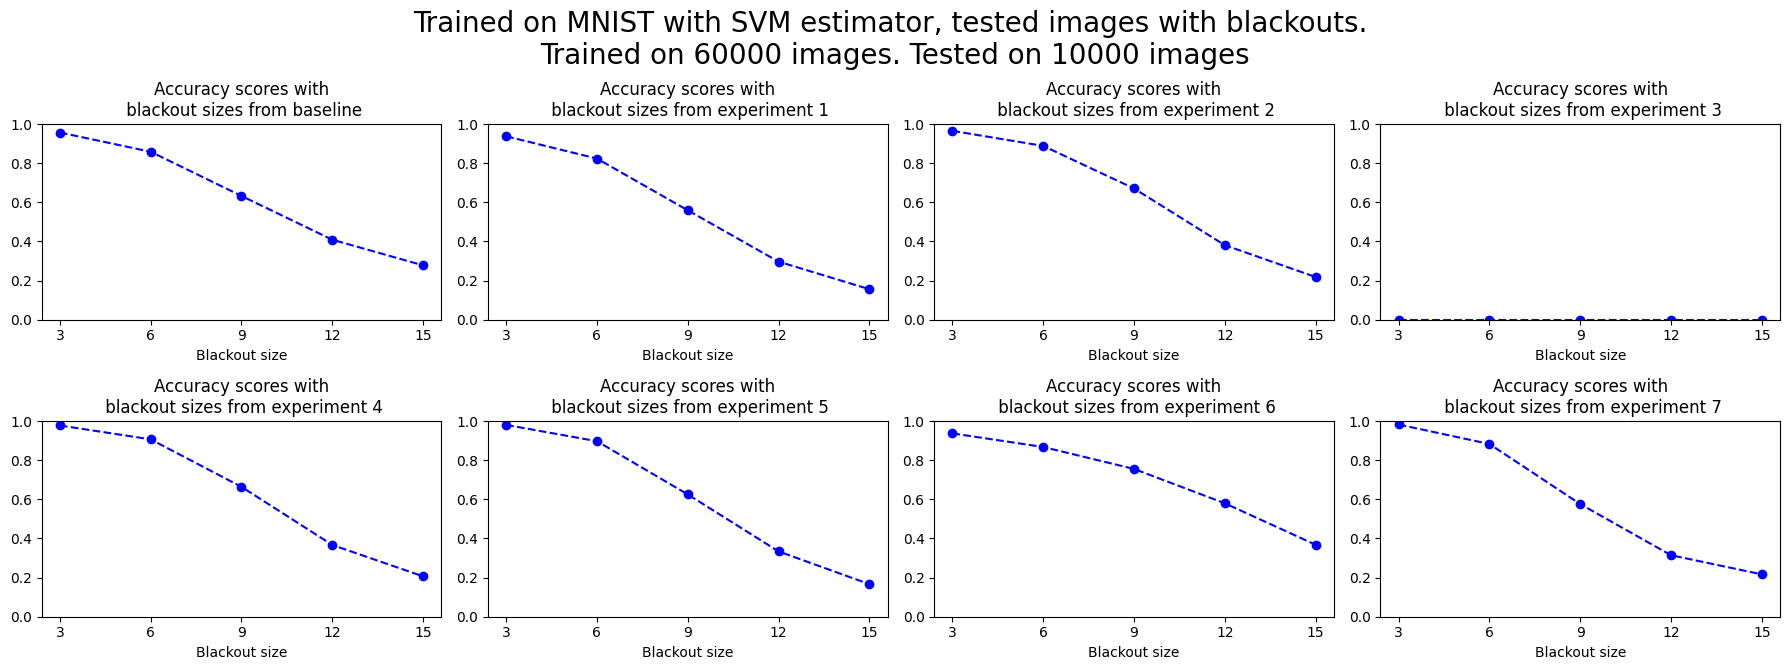

In [100]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
for i in range(9):
    k, j = i // 3, i % 3
    ax[k][j].plot([str(t) for t in blackout_sizes], scores_blackout_svm[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n blackout sizes from experiment {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Blackout size") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with SVM estimator, tested images with blackouts. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)
#fig.delaxes(ax[1,3])

### KNN

In [ ]:
scores_blackout_knn = []

#### Baseline - KNN - No thresholding

In [ ]:
clfs_knn_blackout_bl = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores_blackout = score_clfs_noisy(clfs_knn_blackout_bl, train_flattened, train_labels, blackout_test_flattened, test_labels)
scores_blackout_knn.append(baseline_knn_scores_blackout)
baseline_knn_scores_blackout

#### Baseline - KNN - 0.7 threshold

In [ ]:
clfs_knn_blackout_bl_thr1 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]
baseline_knn_scores_thr1 = score_clfs_noisy(clfs_knn_blackout_bl_thr1, 
                                       train_flattened_blackout_threshold1, 
                                       train_labels, 
                                       test_flattened_blackout_threshold1, 
                                       test_labels)

scores_blackout_knn.append(baseline_knn_scores_thr1)
baseline_knn_scores_thr1

#### Baseline - KNN - 0.85 threshold

In [ ]:
clfs_knn_blackout_bl_thr2 = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(noises))]

baseline_knn_scores_thr2 = score_clfs_noisy(clfs_knn_blackout_bl_thr2, 
                                       train_flattened_blackout_threshold2, 
                                       train_labels, 
                                       test_flattened_blackout_threshold2, 
                                       test_labels)

scores_blackout_knn.append(baseline_knn_scores_thr2)
baseline_knn_scores_thr2

#### Experiment 1 - KNN

In [ ]:
clfs_knn_exp1_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp1_knn = score_clfs_noisy(clfs_knn_exp1_blackout, exp_1_train_transformed, train_labels, exp_1_test_blackout_transformed, test_labels)
scores_blackout_knn.append(scores_blackout_exp1_knn)
scores_blackout_exp1_knn

#### Experiment 2 - KNN

In [ ]:
clfs_knn_exp2_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp2_knn = score_clfs_noisy(clfs_knn_exp2_blackout, exp_2_train_transformed, train_labels, exp_2_test_blackout_transformed, test_labels)
scores_blackout_knn.append(scores_blackout_exp2_knn)
scores_blackout_exp2_knn

#### Experiment 4 - KNN

In [ ]:
clfs_knn_exp4_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp4_knn = score_clfs_noisy(clfs_knn_exp4_blackout, exp_4_train_transformed, train_labels, exp_4_test_blackout_transformed, test_labels)
scores_blackout_knn.append(scores_blackout_exp4_knn)
scores_blackout_exp4_knn

#### Experiment 6 - KNN

In [ ]:
clfs_knn_exp6_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp6_knn = score_clfs_noisy(clfs_knn_exp6_blackout, exp_6_train_transformed, train_labels, exp_6_test_blackout_transformed, test_labels)
scores_blackout_knn.append(scores_blackout_exp6_knn)
scores_blackout_exp6_knn

#### Experiment 7 - KNN

In [ ]:
clfs_knn_exp7_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp7_knn = score_clfs_noisy(clfs_knn_exp7_blackout, exp_7_train_transformed, train_labels, exp_7_test_blackout_transformed, test_labels)
scores_blackout_knn.append(scores_blackout_exp7_knn)
scores_blackout_exp7_knn

#### Experiment 8 - KNN

In [ ]:
clfs_knn_exp8_blackout = [KNeighborsClassifier(n_neighbors=5, p=2) for _ in range(len(blackout_sizes))]
scores_blackout_exp8_knn = score_clfs_noisy(clfs_knn_exp8_blackout, exp_8_train_transformed, train_labels, exp_8_test_blackout_transformed, test_labels)
scores_blackout_knn.append(scores_blackout_exp8_knn)
scores_blackout_exp8_knn

#### KNN - Results

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
for i in range(9):
    k, j = i // 3, i % 3
    ax[k][j].plot([str(t) for t in blackout_sizes], scores_blackout_knn[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n blackout sizes from {experiments[i]}")
    ax[k][j].set_ylim([.0, 1.])
    ax[k][j].set_xlabel("Blackout size") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with KNN estimator, tested images with blackouts. \nTrained on {data_train.shape[0]} images. Tested on {data_test.shape[0]} images",
             fontsize=20)

### Testing with CNN - Baseline

In [ ]:
cnn_blackout_scores_noise = []

In [96]:
def score_cnn_bl(clfs, X_train, y_train, X_test, y_test):
    scores = []
    batch_size = 128
    epochs = 15
    X_tr = np.array(X_train)

    for i, clf in enumerate(clfs):
        X_te = np.array([black_out_section(img, blackout_sizes[i]) for img in X_test])
        clf.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        clf.fit(X_tr, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        scores.append(clf.evaluate(X_te, y_test, verbose=0)[1])
    return scores

In [97]:
clfs_blackout_bl_cnn = [make_model_baseline(input_shape=input_shape, num_classes=classes) for _ in range(len(blackout_sizes))]
cnn_blackout_scores_noise.append(score_cnn_bl(clfs_blackout_bl_cnn, mnist_train_pixelshape, train_labels_binary, mnist_test_pixelshape, test_labels_binary))

Text(0.5, 1.0, 'CNN accuracy scores with blackout sizes from baseline, SVM')

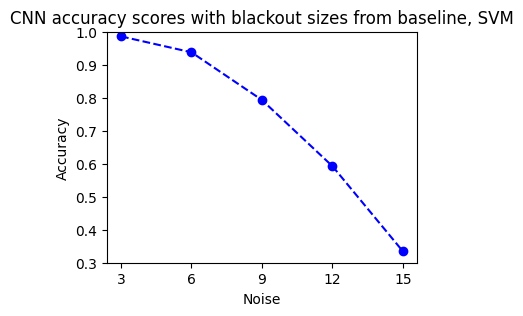

In [99]:
plt.plot([str(t) for t in blackout_sizes], cnn_blackout_scores_noise[0], linestyle='--', marker='o', color='b', label='Accuracy score')
plt.ylim([.3, 1.])
plt.ylabel("Accuracy")
plt.xlabel("Noise")
plt.title("CNN accuracy scores with blackout sizes from baseline, SVM")